In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# load csv
df = pd.read_csv('CST_final_results.csv')

# Data cleaning
df['rep_durations'] = df['rep_durations'].apply(lambda x: eval(x))
df['max_angles'] = df['max_angles'].apply(lambda x: eval(x))

df = df[df.columns.drop(list(df.filter(regex='circular_mean')))]
df = df[df.columns.drop(list(df.filter(regex='circular_std')))]
df = df[df.columns.drop(list(df.filter(regex='mean_magnitude')))]
df = df[df.columns.drop(list(df.filter(regex='RIGHT')))]
df = df[df.columns.drop(list(df.filter(regex='ANKLE')))]
df = df[df.columns.drop(list(df.filter(regex='TOE')))]
df=df.drop(columns=['test'])
df=df.drop(columns=['reps'])


# frailty score of passed is 0
df['frailty_score'] = df['status'].apply(lambda x: 1 if x == 'PASSED' else 100)

# feature engineering
# average max angle

df['avg_max_angle'] = df['max_angles'].apply(lambda x: np.mean(x))
# highest max angle in the rep
df['max_max_angle'] = df['max_angles'].apply(lambda x: max(x))
# lowest max angle in the rep
df['min_max_angle'] = df['max_angles'].apply(lambda x: min(x))
# average duration
df['avg_duration'] = df['rep_durations'].apply(lambda x: np.mean(x))
# highest duration in the rep
df['max_duration'] = df['rep_durations'].apply(lambda x: max(x))
df.drop(columns=['max_angles'], inplace=True)
df.drop(columns=['rep_durations'], inplace=True)
df.drop(columns=['violations'], inplace=True)

# intermediate_row = {
#     'status': 'PASSED',
#     'time': 11.428,  # Given time for the intermediate row
#     'NOSE_std_dev': np.random.uniform(17.41694, 34.04457),  # Lower than frailty score 1, higher than 100
#     'LEFT_SHOULDER_std_dev': np.random.uniform(8.010344, 23.260189),
#     'LEFT_HIP_std_dev': np.random.uniform(19.053679, 20.432018),
#     'LEFT_KNEE_std_dev': np.random.uniform(4.008949, 19.719614),
#     'frailty_score': 40,  # Given frailty score
#     'avg_max_angle': np.mean([162.764387, 162.322622]),  # Interpolated average
#     'max_max_angle': np.mean([166.504825, 171.009481]),  # Interpolated average
#     'min_max_angle': np.mean([156.993705, 146.330222]),  # Interpolated average
#     'avg_duration': 11.428/5,  # Interpolated average
#     'max_duration': np.mean([1.866667, 5.733333])  # Interpolated average

# }

# df.loc[len(df)] = intermediate_row
# sort the data by frailty score
df = df.sort_values(by=['frailty_score'])
df

,status,time,NOSE_std_dev,LEFT_SHOULDER_std_dev,LEFT_HIP_std_dev,LEFT_KNEE_std_dev,frailty_score,avg_max_angle,max_max_angle,min_max_angle,avg_duration,max_duration
0,PASSED,8.766667,34.044570,23.260189,19.053679,19.719614,1,162.764387,166.504825,156.993705,1.573333,1.866667
1,FAILED,16.066667,7.489442,9.597351,25.967289,6.156676,100,174.365169,179.924467,161.248234,2.840000,3.666667


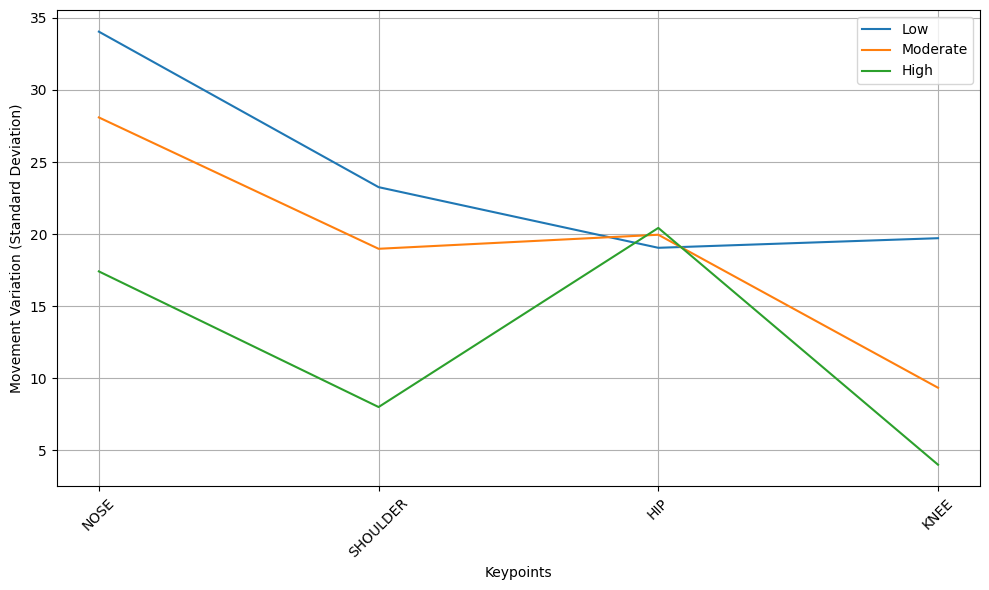

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Define keypoints columns and remove 'LEFT_' and '_std_dev' for readability
original_columns = ['NOSE_std_dev', 'LEFT_SHOULDER_std_dev', 'LEFT_HIP_std_dev', 'LEFT_KNEE_std_dev']
keypoints_columns = ['NOSE', 'SHOULDER', 'HIP', 'KNEE']  # Simplified for the chart

# Plot
plt.figure(figsize=(10, 6))

def frailty_level(score):
    if score == 1:
        return 'Low'
    elif score == 100:
        return 'High'
    else:
        return 'Moderate'

for index, row in df.iterrows():
    # Extract std_dev columns for plotting (without renaming the columns in the dataframe)
    std_dev_values = [row[original_columns[i]] for i in range(len(original_columns))]
    plt.plot(keypoints_columns, std_dev_values, label=f'{frailty_level(row["frailty_score"])}')

plt.xlabel('Keypoints')
plt.ylabel('Movement Variation (Standard Deviation)')
# plt.title('Standard Deviation of Motion Magnitudes for Each Keypoint')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


Index(['time', 'max_max_angle', 'min_max_angle', 'RIGHT_SHOULDER_std_dev',
       'RIGHT_HIP_std_dev', 'RIGHT_KNEE_std_dev', 'RIGHT_ANKLE_std_dev',
       'frailty_score', 'avg_duration'],
      dtype='object')


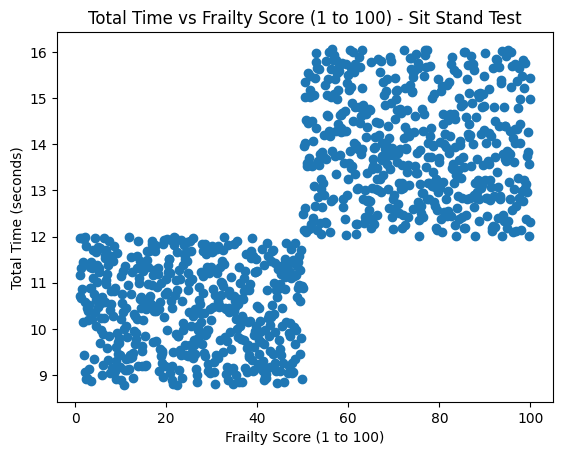

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df contains the benchmarks for the lowest and highest frailty subjects
lowest_frailty_benchmark = df.iloc[0]  # Use this for upper bounds (least frail)
highest_frailty_benchmark = df.iloc[-1]  # Use this for lower bounds (most frail)

# Generate 1000 samples of synthetic data with frailty scores from 1 to 100
n_samples = 1000
frailty_scores = np.round(np.linspace(1, 100, n_samples), 1)

# List to store generated synthetic data
synthetic_data = []

# Helper function to interpolate between the two benchmarks
def interpolate_value(low_value, high_value, score, min_score=0, max_score=100):
    return low_value + (high_value - low_value) * ((score - min_score) / (max_score - min_score))


# Generate synthetic data based on frailty score rules
for score in frailty_scores:
    # Rule: for scores > 50, total time > 12 seconds, scaled by frailty score
    if score > 50:
        total_time = np.random.uniform(12, highest_frailty_benchmark['time'])  # Time increases with frailty score
    else:
        total_time = np.random.uniform(lowest_frailty_benchmark['time'], 12)  # Faster times for lower scores
    
    # Max and Min Angles: Decrease with frailty score, bounded by benchmarks
    max_max_angle = np.random.uniform(highest_frailty_benchmark['max_max_angle'], lowest_frailty_benchmark['max_max_angle'])
    min_max_angle = np.random.uniform(highest_frailty_benchmark['min_max_angle'], lowest_frailty_benchmark['min_max_angle'])

    # Joint movement variation: Decrease with frailty score, bounded by benchmarks
    shoulder_std = np.random.uniform(highest_frailty_benchmark['LEFT_SHOULDER_std_dev'], lowest_frailty_benchmark['LEFT_SHOULDER_std_dev'])
    hip_std = np.random.uniform(highest_frailty_benchmark['LEFT_HIP_std_dev'], lowest_frailty_benchmark['LEFT_HIP_std_dev'])
    knee_std = np.random.uniform(highest_frailty_benchmark['LEFT_KNEE_std_dev'], lowest_frailty_benchmark['LEFT_KNEE_std_dev'])
    ankle_std = np.random.uniform(highest_frailty_benchmark['NOSE_std_dev'], lowest_frailty_benchmark['NOSE_std_dev'])
     # Interpolate max and min angles based on the score (frailty)
    # max_max_angle = interpolate_value(
    #     highest_frailty_benchmark['max_max_angle'], lowest_frailty_benchmark['max_max_angle'], score
    # )
    # min_max_angle = interpolate_value(
    #     highest_frailty_benchmark['min_max_angle'], lowest_frailty_benchmark['min_max_angle'], score
    # )
    
    # # Interpolate joint movement variation (std dev) based on the score
    # shoulder_std = interpolate_value(
    #     highest_frailty_benchmark['LEFT_SHOULDER_std_dev'], lowest_frailty_benchmark['LEFT_SHOULDER_std_dev'], score
    # )
    # hip_std = interpolate_value(
    #     highest_frailty_benchmark['LEFT_HIP_std_dev'], lowest_frailty_benchmark['LEFT_HIP_std_dev'], score
    # )
    # knee_std = interpolate_value(
    #     highest_frailty_benchmark['LEFT_KNEE_std_dev'], lowest_frailty_benchmark['LEFT_KNEE_std_dev'], score
    # )
    # ankle_std = interpolate_value(
    #     highest_frailty_benchmark['NOSE_std_dev'], lowest_frailty_benchmark['NOSE_std_dev'], score
    # )


    # Append the generated data for this row
    synthetic_data.append({
        'time': total_time,
        'max_max_angle': max_max_angle,
        'min_max_angle': min_max_angle,
        'RIGHT_SHOULDER_std_dev': shoulder_std,
        'RIGHT_HIP_std_dev': hip_std,
        'RIGHT_KNEE_std_dev': knee_std,
        'RIGHT_ANKLE_std_dev': ankle_std,
        'frailty_score': score
    })

# 



# Convert the list of synthetic data to a DataFrame
df_synthetic = pd.DataFrame(synthetic_data)
df_synthetic['time'] = pd.to_numeric(df_synthetic['time'], errors='coerce')  # Convert to numeric, NaN for invalid parsing
df_synthetic['avg_duration'] = df_synthetic['time'].apply(lambda x: x/5)
# Save the synthetic data to a CSV file
df_synthetic.to_csv('synthetic_data_sit_stand.csv', index=False)

# Print the synthetic DataFrame
print(df_synthetic.columns)

# Plot the synthetic data for visualizing the relationship between frailty score and total time
plt.scatter(df_synthetic['frailty_score'], df_synthetic['time'])
plt.xlabel('Frailty Score (1 to 100)')
plt.ylabel('Total Time (seconds)')
plt.title('Total Time vs Frailty Score (1 to 100) - Sit Stand Test')
plt.show()


In [16]:
# # Add noise
# import numpy as np

# # Initial values
# initial_values = {
#     'time': [8.766667, 16.066667],
#     'NOSE_std_dev': [34.044570, 7.489442],
#     'LEFT_SHOULDER_std_dev': [23.260189, 9.597351],
#     'LEFT_HIP_std_dev': [19.053679, 25.967289],
#     'LEFT_KNEE_std_dev': [19.719614, 6.156676],
#     'avg_max_angle': [162.764387, 174.365169],
#     'max_max_angle': [166.504825, 179.924467],
#     'min_max_angle': [156.993705, 161.248234],
#     'avg_duration': [1.573333, 2.840000],
#     'max_duration': [1.866667, 3.666667]
# }

# # Standard deviations from initial values (estimate how much noise to add)
# std_devs = {
#     'time': np.std(initial_values['time']),
#     'LEFT_SHOULDER_std_dev': np.std(initial_values['LEFT_SHOULDER_std_dev']),
#     'LEFT_HIP_std_dev': np.std(initial_values['LEFT_HIP_std_dev']),
#     'LEFT_KNEE_std_dev': np.std(initial_values['LEFT_KNEE_std_dev']),
#     'avg_max_angle': np.std(initial_values['avg_max_angle']),
#     'max_max_angle': np.std(initial_values['max_max_angle']),
#     'min_max_angle': np.std(initial_values['min_max_angle']),
#     'avg_duration': np.std(initial_values['avg_duration']),
#     'max_duration': np.std(initial_values['max_duration'])
# }

# # Example function to add noise to the synthetic data
# def add_noise_to_synthetic_data(data, std_devs):
#     noisy_data = []
    
#     for row in data:
#         noisy_row = {
#             'time': row['time'] + np.random.normal(0, std_devs['time']),
#             'LEFT_SHOULDER_std_dev': row['LEFT_SHOULDER_std_dev'] + np.random.normal(0, std_devs['LEFT_SHOULDER_std_dev']),
#             'LEFT_HIP_std_dev': row['LEFT_HIP_std_dev'] + np.random.normal(0, std_devs['LEFT_HIP_std_dev']),
#             'LEFT_KNEE_std_dev': row['LEFT_KNEE_std_dev'] + np.random.normal(0, std_devs['LEFT_KNEE_std_dev']),
#             'frailty_score': row['frailty_score'],  # No noise for this as it's predefined
#             'avg_max_angle': row['avg_max_angle'] + np.random.normal(0, std_devs['avg_max_angle']),
#             'max_max_angle': row['max_max_angle'] + np.random.normal(0, std_devs['max_max_angle']),
#             'min_max_angle': row['min_max_angle'] + np.random.normal(0, std_devs['min_max_angle']),
#             'avg_duration': row['avg_duration'] + np.random.normal(0, std_devs['avg_duration']),
#             'max_duration': row['max_duration'] + np.random.normal(0, std_devs['max_duration'])
#         }
#         noisy_data.append(noisy_row)
    
#     return noisy_data

# # Assuming 'synthetic_data' is your previously generated data
# noisy_synthetic_data = add_noise_to_synthetic_data(synthetic_data, std_devs)

# # Convert back to DataFrame to view the results
# noisy_synthetic_df = pd.DataFrame(noisy_synthetic_data)

# # Display the noisy synthetic data
# noisy_synthetic_df.head()


# # df_synthetic.to_csv('synthetic_data_sit_stand.csv', index=False)

# # # Print the synthetic DataFrame
# # print(df_synthetic.columns)

# # # Plot the synthetic data for visualizing the relationship between frailty score and total time
# # plt.scatter(df_synthetic['frailty_score'], df_synthetic['time'])
# # plt.xlabel('Frailty Score (1 to 100)')
# # plt.ylabel('Total Time (seconds)')
# # plt.title('Total Time vs Frailty Score (1 to 100) - Sit Stand Test')
# # plt.show()



KeyError: 'LEFT_SHOULDER_std_dev'

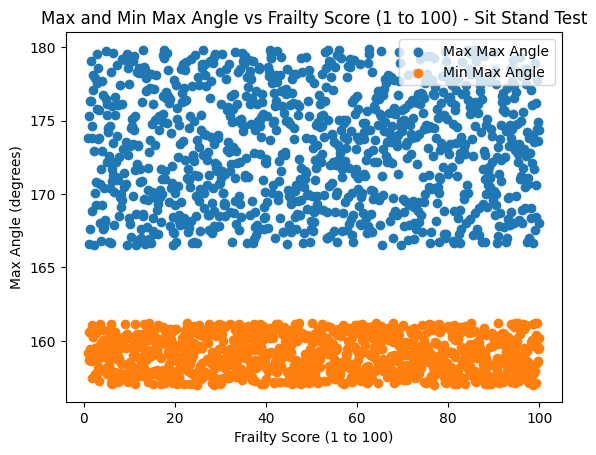

In [18]:
# plot the synthetic data for visualizing the relationship between frailty score and max angles
plt.scatter(df_synthetic['frailty_score'], df_synthetic['max_max_angle'], label='Max Max Angle')
plt.scatter(df_synthetic['frailty_score'], df_synthetic['min_max_angle'], label='Min Max Angle')
plt.xlabel('Frailty Score (1 to 100)')
plt.ylabel('Max Angle (degrees)')
plt.title('Max and Min Max Angle vs Frailty Score (1 to 100) - Sit Stand Test')
plt.legend()
plt.show()


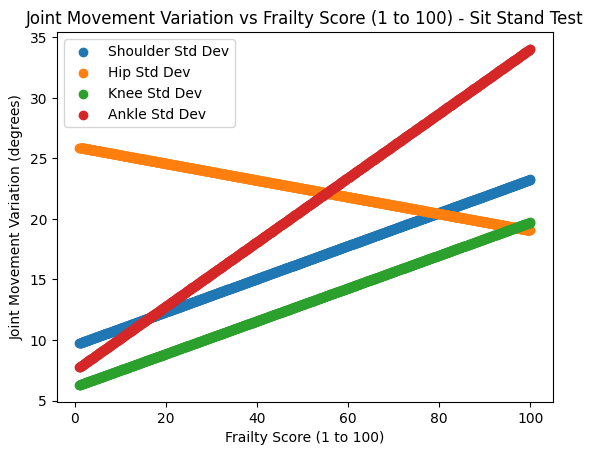

In [9]:
# plot the synthetic data for visualizing the relationship between frailty score and joint movement variation
plt.scatter(df_synthetic['frailty_score'], df_synthetic['RIGHT_SHOULDER_std_dev'], label='Shoulder Std Dev')
plt.scatter(df_synthetic['frailty_score'], df_synthetic['RIGHT_HIP_std_dev'], label='Hip Std Dev')
plt.scatter(df_synthetic['frailty_score'], df_synthetic['RIGHT_KNEE_std_dev'], label='Knee Std Dev')
plt.scatter(df_synthetic['frailty_score'], df_synthetic['RIGHT_ANKLE_std_dev'], label='Ankle Std Dev')
plt.xlabel('Frailty Score (1 to 100)')
plt.ylabel('Joint Movement Variation (degrees)')
plt.title('Joint Movement Variation vs Frailty Score (1 to 100) - Sit Stand Test')
plt.legend()
plt.show()


In [4]:
import pandas as pd
imported_syntethic_df = pd.read_csv('synthetic_data_sit_stand.csv')
imported_syntethic_df['avg_duration']

# Feature engineering
imported_syntethic_df['shoulder_hip_ratio'] = imported_syntethic_df['RIGHT_SHOULDER_std_dev'] / imported_syntethic_df['RIGHT_HIP_std_dev']
imported_syntethic_df['knee_ankle_ratio'] = imported_syntethic_df['RIGHT_KNEE_std_dev'] / imported_syntethic_df['RIGHT_ANKLE_std_dev']
imported_syntethic_df['hip_knee_ratio'] = imported_syntethic_df['RIGHT_HIP_std_dev'] / imported_syntethic_df['RIGHT_KNEE_std_dev']
imported_syntethic_df['angle_range'] = imported_syntethic_df['max_max_angle'] - imported_syntethic_df['min_max_angle']
imported_syntethic_df['movement_stability'] = (imported_syntethic_df['RIGHT_SHOULDER_std_dev'] + 
                                      imported_syntethic_df['RIGHT_HIP_std_dev'] + 
                                      imported_syntethic_df['RIGHT_KNEE_std_dev'] + 
                                      imported_syntethic_df['RIGHT_ANKLE_std_dev']) / 4


In [5]:
X = imported_syntethic_df.drop(columns=['frailty_score'])
print(X.columns)
y = imported_syntethic_df['frailty_score']
# y

imported_syntethic_df

Index(['time', 'max_max_angle', 'min_max_angle', 'RIGHT_SHOULDER_std_dev',
       'RIGHT_HIP_std_dev', 'RIGHT_KNEE_std_dev', 'RIGHT_ANKLE_std_dev',
       'avg_duration', 'shoulder_hip_ratio', 'knee_ankle_ratio',
       'hip_knee_ratio', 'angle_range', 'movement_stability'],
      dtype='object')


,time,max_max_angle,min_max_angle,RIGHT_SHOULDER_std_dev,RIGHT_HIP_std_dev,RIGHT_KNEE_std_dev,RIGHT_ANKLE_std_dev,frailty_score,avg_duration,shoulder_hip_ratio,knee_ankle_ratio,hip_knee_ratio,angle_range,movement_stability
0,10.705668,173.848038,159.159943,15.120663,25.952705,18.440055,23.016990,1.0,2.141134,0.582624,0.801150,1.407409,14.688094,20.632603
1,11.161821,175.335262,158.710711,13.689695,20.792430,15.438871,8.727938,1.1,2.232364,0.658398,1.768902,1.346758,16.624551,14.662233
2,11.970253,166.623635,160.589683,22.924844,21.975140,10.100649,19.873109,1.2,2.394051,1.043217,0.508257,2.175617,6.033952,18.718436
3,11.327105,176.318353,159.417518,10.583483,19.376668,10.838830,19.284666,1.3,2.265421,0.546197,0.562044,1.787708,16.900835,15.020912
4,10.662900,167.624900,158.848442,13.793909,25.175069,12.013403,16.975546,1.4,2.132580,0.547919,0.707689,2.095582,8.776459,16.989482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.006227,177.775513,158.504507,19.786958,23.347726,15.689118,19.274178,99.6,2.401245,0.847490,0.813997,1.488148,19.271006,19.524495
996,13.578598,173.620396,159.458523,20.981752,23.735753,19.054709,10.308790,99.7,2.715720,0.883972,1.848394,1.245663,14.161873,18.520251
997,12.319391,174.886787,158.617005,20.591771,24.811576,6.933216,29.323925,99.8,2.463878,0.829926,0.236435,3.578654,16.269782,20.415122
998,15.424317,174.338319,159.504495,16.807461,20.861453,11.888823,10.575398,99.9,3.084863,0.805671,1.124196,1.754711,14.833823,15.033284


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Features (X) and target (y)
X = imported_syntethic_df.drop(columns=['frailty_score'])  # All columns except frailty_score
y = imported_syntethic_df['frailty_score']  # Target variable

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions on the test set
print(X_test.shape)
print(X_test.columns)
y_pred = lr_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2_score = lr_model.score(X_test, y_test)
# get random row from the test set
testing_input = X_test.sample()
print(testing_input)
print(testing_input.shape)
frailty_score = lr_model.predict(testing_input)
print(frailty_score)



print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2_score:.2f}')

# print(lr_model.predict(testing_input.drop(columns=['frailty_score']).values.reshape(1, -1)))

(200, 13)
Index(['time', 'max_max_angle', 'min_max_angle', 'RIGHT_SHOULDER_std_dev',
       'RIGHT_HIP_std_dev', 'RIGHT_KNEE_std_dev', 'RIGHT_ANKLE_std_dev',
       'avg_duration', 'shoulder_hip_ratio', 'knee_ankle_ratio',
       'hip_knee_ratio', 'angle_range', 'movement_stability'],
      dtype='object')
          time  max_max_angle  min_max_angle  RIGHT_SHOULDER_std_dev  \
522  12.665919     169.941459     159.198881               11.277914   

     RIGHT_HIP_std_dev  RIGHT_KNEE_std_dev  RIGHT_ANKLE_std_dev  avg_duration  \
522          22.063957           18.847973            13.174387      2.533184   

     shoulder_hip_ratio  knee_ankle_ratio  hip_knee_ratio  angle_range  \
522            0.511146          1.430653        1.170628    10.742578   

     movement_stability  
522           16.341058  
(1, 13)
[53.24217236]
Mean Absolute Error: 15.85
Mean Squared Error: 387.25
R^2 Score: 0.52


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # Importing Random Forest Regressor
from sklearn.metrics import mean_squared_error, mean_absolute_error 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust the number of trees (n_estimators)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
rf_mae = mean_absolute_error(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
rf_r2score = rf_model.score(X_test, y_test)

# Print the evaluation metrics
print(f'Mean Absolute Error: {rf_mae:.2f}')
print(f'Mean Squared Error: {rf_mse:.2f}')
print(f'R^2 Score: {rf_r2score:.2f}')

Mean Absolute Error: 12.82
Mean Squared Error: 227.49
R^2 Score: 0.72


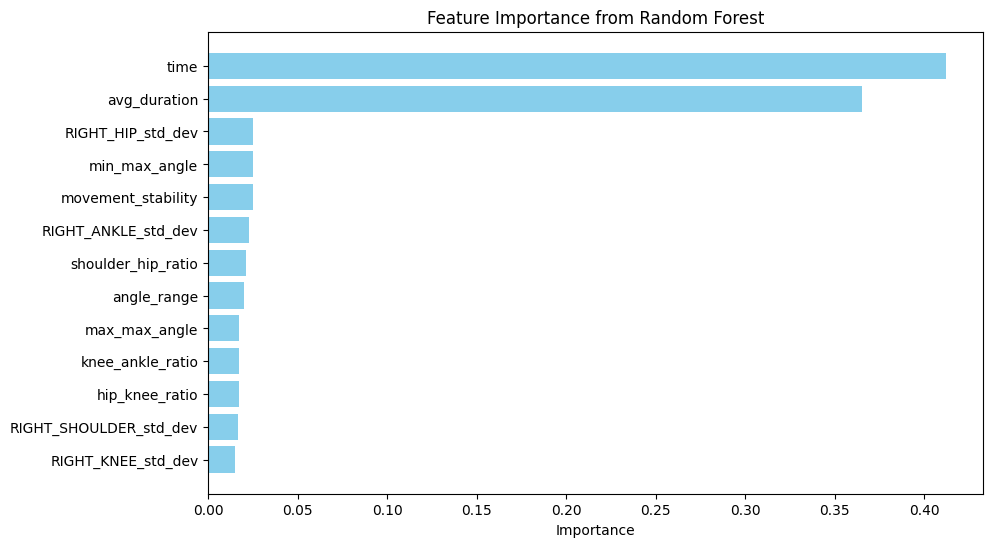

In [11]:
# Import the required library for plotting
import matplotlib.pyplot as plt

# Get the feature importances from the Random Forest model
feature_importances = rf_model.feature_importances_

# Get the feature names from the dataset
feature_names = X_train.columns

# Create a DataFrame for the feature importances
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the feature importances in descending order
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # To display the most important features on top
plt.show()


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],        # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],         # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]             # Whether bootstrap samples are used when building trees
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# Fit the grid search model to the training data (without weighting)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print(f"Best parameters found: {grid_search.best_params_}")

# Get the best estimator (model with the best parameters)
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set (without weighting)
y_pred_best_rf = best_rf_model.predict(X_test)

# Print predictions
print(f"y_pred_best_rf: {y_pred_best_rf}")

# Calculate performance metrics
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)

print(f"Best Random Forest Model MAE: {mae_best_rf:.2f}")
print(f"Best Random Forest Model MSE: {mse_best_rf:.2f}")
print(f"Best Random Forest Model R^2 Score: {best_rf_model.score(X_test, y_test):.2f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=

/Users/brennanlee/Desktop/opencv-healthcare/myenv/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
y_pred_best_rf: [69.44610837 70.0328369  76.8901196  83.66863492 26.07278091 74.34860507
 76.12072576 81.72546834 75.50422041 26.26755378 74.25964489 26.73975098
 69.14555052 77.93891114 73.14585722 74.18311627 31.14333814 69.41633305
 78.54225115 20.64965491 67.05152195 24.20703033 24.09696763 66.88847882
 21.33853138 25.08512767 19.3605927  78.53954485 81.47086626 76.24786075
 25.14374782 18.45895657 71.64054925 75.54997663 25.08708861 29.79573343
 74.13602056 79.42862853 80.30706646 31.65442376 23.22135899 24.70728654
 35.05029834 79.3969052  31.91502231 26.31567996 72.46795255 73.07968403
 20.70877588 72.08344834 72.80321928 81.03831733 21.48079767 77.22232075
 28.13630453 27.90125383 67.65788536 29.22392576 25.5418947  71.13062841
 30.59529076 28.2856827  75.17233331 24.92679117 75.58577918 77.38919413
 82.3329469  72.10104587 24.53616795 74.62771607 26.

In [13]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_score_xgb = xgb_model.score(X_test, y_test)

# Print the evaluation metrics
print(f"XGBoost Model MAE: {mae_xgb:.2f}")
print(f"XGBoost Model MSE: {mse_xgb:.2f}")
print(f"XGBoost Model R^2 Score: {r2_score_xgb:.2f}")


XGBoost Model MAE: 12.76
XGBoost Model MSE: 229.35
XGBoost Model R^2 Score: 0.71


In [14]:
# print all scores for different models
print(f"Linear Regression Model MAE: {mae:.2f}")
print(f"Linear Regression Model MSE: {mse:.2f}")
print(f"Linear Regression Model R^2 Score: {r2_score:.2f}")

print(f"Random Forest Model MAE: {rf_mae:.2f}")
print(f"Random Forest Model MSE: {rf_mse:.2f}")
print(f"Random Forest Model R^2 Score: {rf_r2score:.2f}")

print(f"Best Random Forest Model MAE: {mae_best_rf:.2f}")
print(f"Best Random Forest Model MSE: {mse_best_rf:.2f}")
print(f"Best Random Forest Model R^2 Score: {best_rf_model.score(X_test, y_test):.2f}")

print(f"XGBoost Model MAE: {mae_xgb:.2f}")
print(f"XGBoost Model MSE: {mse_xgb:.2f}")
print(f"XGBoost Model R^2 Score: {r2_score_xgb:.2f}")


# present in a table format

# Create a DataFrame to display the results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Best Random Forest', 'XGBoost'],
    'MAE': [mae, rf_mae, mae_best_rf, mae_xgb],
    'MSE': [mse, rf_mse, mse_best_rf, mse_xgb],
    'R^2 Score': [r2_score, rf_r2score, best_rf_model.score(X_test, y_test), r2_score_xgb]
})
results


Linear Regression Model MAE: 15.85
Linear Regression Model MSE: 387.25
Linear Regression Model R^2 Score: 0.52
Random Forest Model MAE: 12.82
Random Forest Model MSE: 227.49
Random Forest Model R^2 Score: 0.72
Best Random Forest Model MAE: 12.50
Best Random Forest Model MSE: 214.73
Best Random Forest Model R^2 Score: 0.73
XGBoost Model MAE: 12.76
XGBoost Model MSE: 229.35
XGBoost Model R^2 Score: 0.71


,Model,MAE,MSE,R^2 Score
0,Linear Regression,15.847743,387.248101,0.517605
1,Random Forest,12.822545,227.492974,0.716612
2,Best Random Forest,12.495471,214.731067,0.732509
3,XGBoost,12.762358,229.349266,0.714299


In [28]:
import joblib

# get current timestamp
import datetime
now = datetime.datetime.now()
# Save the best Random Forest model to a file
joblib.dump(best_rf_model, f'5ST_rf_model_{now}.pkl')

['5ST_rf_model_2024-10-04 02:43:44.343363.pkl']

In [15]:
type(best_rf_model)

sklearn.ensemble._forest.RandomForestRegressor